<a href="https://colab.research.google.com/github/Bavish2201/Cross-domain-CNN/blob/master/Hyperspectral_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperspectral Image Classification using Cross-domain CNN

## Loading Indian Pines dataset

In [0]:
import numpy as np
import scipy.io
data = scipy.io.loadmat('Indian_pines.mat')['indian_pines']
print(data.shape)

(145, 145, 220)


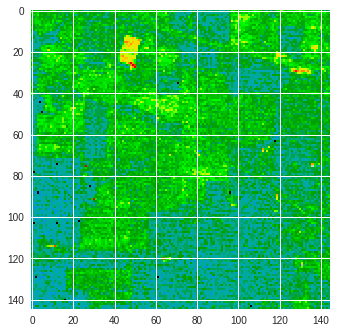

In [0]:
_data = data.transpose((2, 0, 1))

import matplotlib.pyplot as plt
plt.imshow(_data[1], cmap='nipy_spectral')


In [0]:
gt = scipy.io.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
print(gt.shape)

(145, 145)


In [0]:
X = []
step = 5
x = range(0, 145, step)
y = range(0, 145, step)
for i in x:
  for j in y:
    X.append(data[i:i+step, j:j+step])
X = np.array(X)
print(X.shape)

(841, 5, 5, 220)


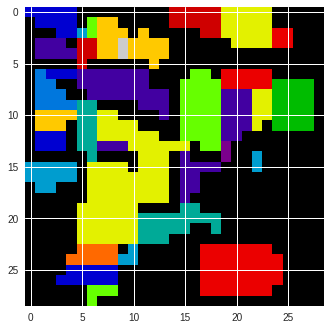

In [0]:
Y = []
for i in x:
  for j in y:
    label = scipy.stats.mode(gt[i:i+step, j:j+step].reshape(step*step, 1))[0][0][0]
    Y.append(label)
Y = np.array(Y).reshape(29, 29)
plt.imshow(Y, cmap='nipy_spectral')

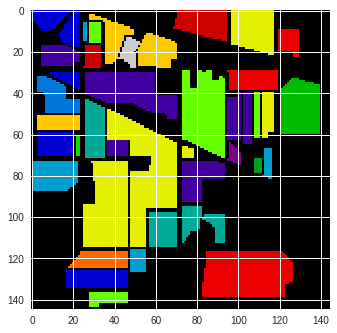

In [0]:
plt.imshow(gt, cmap='nipy_spectral')

## Building the CNN Model

In [0]:
from keras.models import Model
from keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, Input, 
                          concatenate, Add)


#
# ------- DATASET-SPECIFIC HYPERSPECTRAL ANALYSIS LAYERS
#

# for Indian pines dataset
indian_pines_input = Input(shape=(5, 5, 220), name='Indian_Pines_Input')

filter11 = Conv2D(128, (3, 3), padding='same', activation='relu')(indian_pines_input)
filter11 = MaxPooling2D((3, 3))(filter11)

filter12 = Conv2D(128, (5, 5), activation='relu')(indian_pines_input)

filter13 = Conv2D(128, (1, 1), padding='same', activation='relu')(indian_pines_input)
filter13 = MaxPooling2D((5, 5))(filter13)

input1 = concatenate([filter11, filter12, filter13], axis=0)

# for Salinas dataset
salinas_input = Input(shape=(5, 5, 220), name='Salinas_Input')

filter21 = Conv2D(128, (3, 3), padding='same', activation='relu')(salinas_input)
filter21 = MaxPooling2D((3, 3))(filter21)

filter22 = Conv2D(128, (5, 5), activation='relu')(salinas_input)

filter23 = Conv2D(128, (1, 1), padding='same', activation='relu')(salinas_input)
filter23 = MaxPooling2D((5, 5))(filter23)

input2 = concatenate([filter21, filter22, filter23], axis=0)


#
# ---------- SHARED LAYERS ----------------
#

shared_conv1 = Conv2D(128, (1, 1), activation='relu', padding='same')
model1 = shared_conv1(input1)
model2 = shared_conv1(input2)

shared_conv2 = Conv2D(128, (1, 1), activation='relu', padding='same')
model1 = shared_conv2(model1)
model2 = shared_conv2(model2)

shared_conv3 = Conv2D(128, (1, 1), activation='relu', padding='same')
model11 = shared_conv3(model1)
model22 = shared_conv3(model2)

shared_conv3 = Conv2D(128, (1, 1), activation='relu', padding='same')
model11 = shared_conv3(model11)
model22 = shared_conv3(model22)

shared_add1 = Add()
model1 = shared_add1([model1, model11])
model2 = shared_add1([model2, model22])

shared_conv4 = Conv2D(128, (1, 1), activation='relu', padding='same')
model1 = shared_conv4(model1)
model2 = shared_conv4(model2)

shared_conv5 = Conv2D(128, (1, 1), activation='relu', padding='same')
model11 = shared_conv5(model1)
model22 = shared_conv5(model2)

shared_conv6 = Conv2D(128, (1, 1), activation='relu', padding='same')
model11 = shared_conv6(model11)
model22 = shared_conv6(model22)

shared_add2 = Add()
model1 = shared_add2([model1, model11])
model2 = shared_add2([model2, model22])


#
# -------- DATASET-SPECIFIC CLASSIFICATION LAYERS ------------
#

# for indian pines dataset
model1 = Conv2D(128, (1, 1), activation='relu')(model1)
model1 = Conv2D(128, (1, 1), activation='relu')(model1)
model1 = Conv2D(128, (1, 1), activation='relu')(model1)

model1 = Flatten()(model1)
model1 = Dense(8, activation='softmax')(model1)

# for salinas dataset
model2 = Conv2D(128, (1, 1), activation='relu')(model2)
model2 = Conv2D(128, (1, 1), activation='relu')(model2)
model2 = Conv2D(128, (1, 1), activation='relu')(model2)

model2 = Flatten()(model2)
model2 = Dense(16, activation='softmax')(model2)

model = Model(inputs=[indian_pines_input, salinas_input], outputs=[model1, model2])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Indian_Pines_Input (InputLayer) (None, 5, 5, 220)    0                                            
__________________________________________________________________________________________________
Salinas_Input (InputLayer)      (None, 5, 5, 220)    0                                            
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, 5, 5, 128)    253568      Indian_Pines_Input[0][0]         
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 5, 5, 128)    28288       Indian_Pines_Input[0][0]         
__________________________________________________________________________________________________
conv2d_190

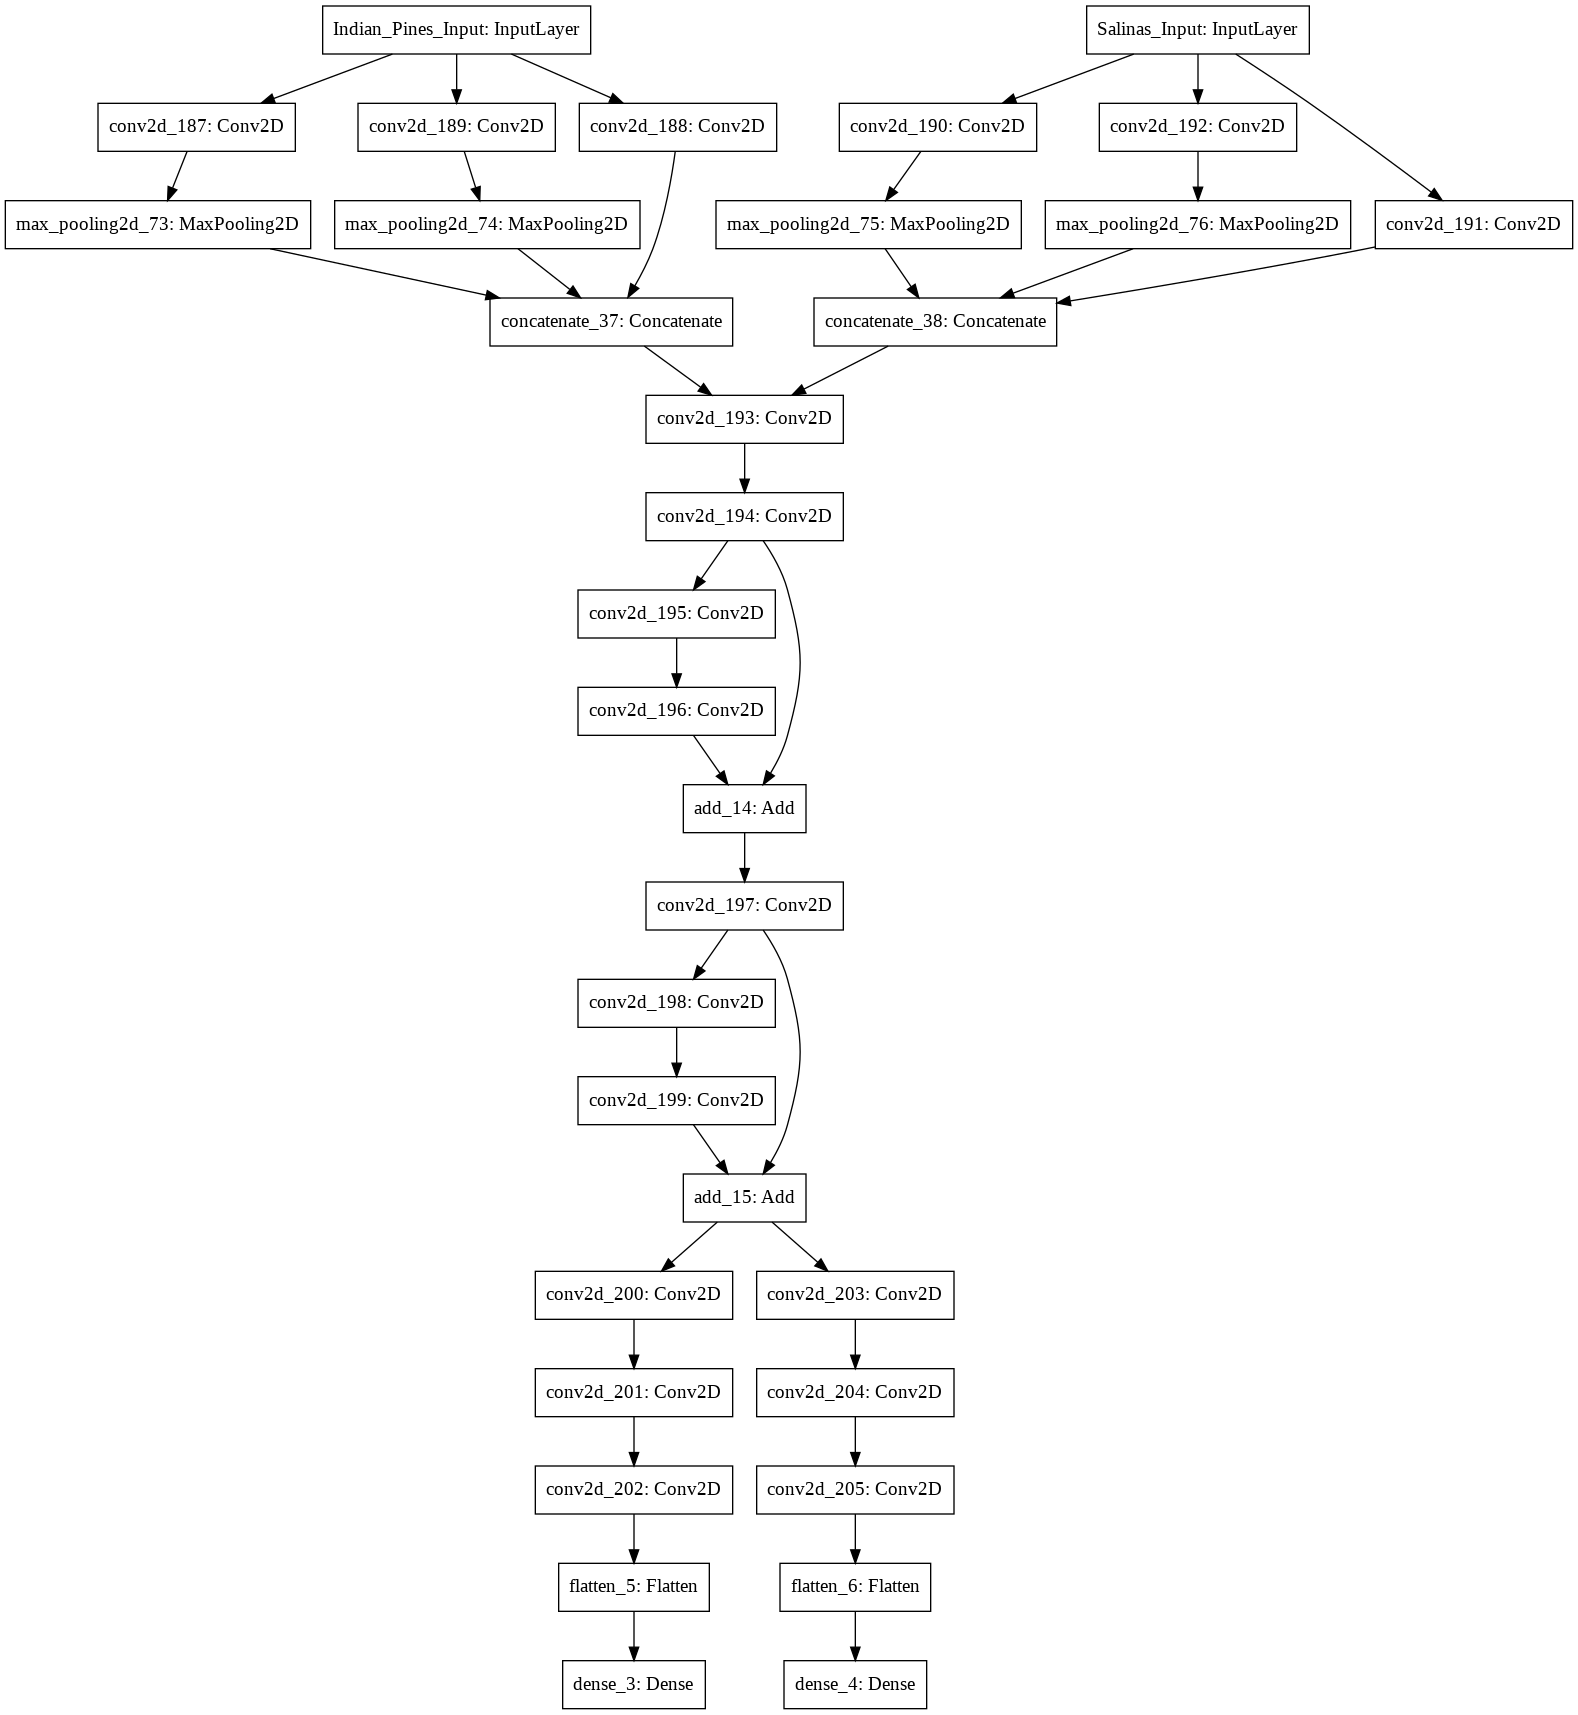

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image, display
display(Image('/content/model.png'))